In [ ]:
using Plots;

In [ ]:
using Gen;

In [ ]:
import Random, Logging

In [ ]:
using StatsBase: mean

# Part 2

In [27]:
@gen function line_model(xs::Vector{Float64})
    # We begin by sampling a slope and intercept for the line.
    # Before we have seen the data, we don't know the values of
    # these parameters, so we treat them as random choices. The
    # distributions they are drawn from represent our prior beliefs
    # about the parameters: in this case, that neither the slope nor the
    # intercept will be more than a couple points away from 0.
    slope = ({:slope} ~ normal(0, 1))
    intercept = ({:intercept} ~ normal(0, 2))
    
    # slope2 = ({:slope} ~ normal(0, 1))
    
    # We define a function to compute y for a given x
    function y(x)
        return slope * x + intercept
    end

    # Given the slope and intercept, we can sample y coordinates
    # for each of the x coordinates in our input vector.
    for (i, x) in enumerate(xs)
        # Note that we name each random choice in this loop
        # slightly differently: the first time through,
        # the name (:y, 1) will be used, then (:y, 2) for
        # the second point, and so on.
        ({(:y, i)} ~ normal(y(x), 0.1))
    end

    # Most of the time, we don't care about the return
    # value of a model, only the random choices it makes.
    # It can sometimems be useful to return something
    # meaningful, however; here, we return the function `y`.
    return y
end;

In [28]:
xs = [-5., -4., -3., -2., -1., 0., 1., 2., 3., 4., 5.];

trace = Gen.simulate(line_model, (xs,));

### Trying to access the same memory results in an error. This is what we want, as if we are sampling a new point from the distribution, we want to make sure we aren't overwriting the previous data.

In [49]:
@gen function sine_model(xs::Vector{Float64})
    
    # < your code here, for sampling a phase, period, and amplitude >
    phase = ({:phase} ~ uniform(0, 2 * pi))
    amplitude = ({:amplitude} ~ gamma(1, 1))
    period = ({:period} ~ gamma(1, 1))



    function y(x)
        return amplitude * sin(2 * pi * x / period + phase)
    end
    
    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(y(x), 0.1)
    end
    
    return y # We return the y function so it can be used for plotting, below. 
end;

In [96]:
function render_trace(trace; show_data=true)
    
    # Pull out xs from the trace
    xs, = get_args(trace)
    
    xmin = minimum(xs)
    xmax = maximum(xs)

    # Pull out the return value, useful for plotting
    y = get_retval(trace)
    
    # Draw the line
    test_xs = collect(range(-5, stop=5, length=1000))
    fig = plot(test_xs, map(y, test_xs), color="black", alpha=0.5, label=nothing,
                xlim=(xmin, xmax), ylim=(xmin, xmax))

    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        
        # Plot the data set
        scatter!(xs, ys, c="black", label=nothing)
    end
    
    return fig
end;

In [31]:
println(trace)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##line_model#312", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:y, 11) => Gen.ChoiceOrCallRecord{Float64}(2.460785062395046, 1.3083068370713469, NaN, true), (:y, 3) => Gen.ChoiceOrCallRecord{Float64}(2.1672477902707437, 1.3067061417809045, NaN, true), :intercept => Gen.ChoiceOrCallRecord{Float64}(2.3163980911522906, -2.282798228351365, NaN, true), (:y, 1) => Gen.ChoiceOrCallRecord{Float64}(2.1802023632392373, 1.2731556955531411, NaN, true), (:y, 8) => Gen.ChoiceOrCallRecord{Float64}(2.3763729853980435, 1.3747929144676012, NaN, true), (:y, 7) => Gen.ChoiceOrCallRecord{Float64}(2.3010302932231816, 1.2484014082964854, NaN, true), (:y, 5) => Gen.ChoiceOrCallRecord{Float64}(2.315029276287009, 1.3214406155891556, NaN, true), (:y, 6) => Gen.ChoiceOrCallRecord{Float64}(2.065

In [32]:
function Plots.grid(renderer::Function, traces)
    Plots.plot(map(renderer, traces)...)
end;

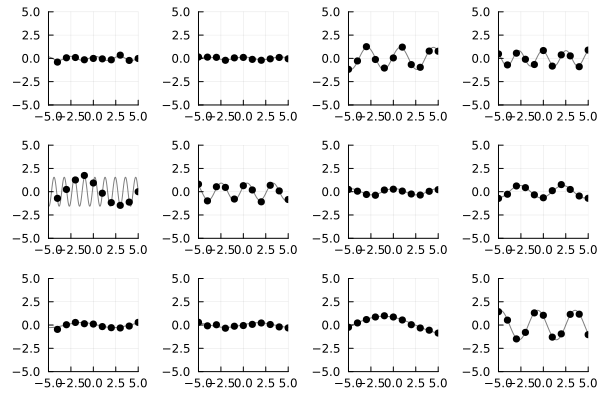

In [33]:
traces = [Gen.simulate(sine_model, (xs,)) for _=1:12];
grid(render_trace, traces)

# Part 3

In [34]:
ys = [6.75003, 6.1568, 4.26414, 1.84894, 3.09686, 1.94026, 1.36411, -0.83959, -0.976, -1.93363, -2.91303];

In [35]:
function do_inference(model, xs, ys, amount_of_computation)
    
    # Create a choice map that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;

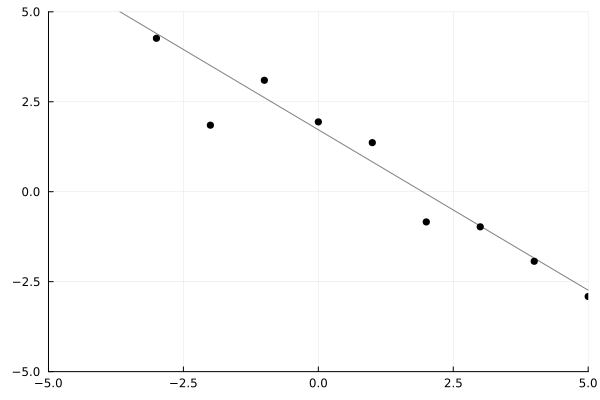

In [36]:
trace = do_inference(line_model, xs, ys, 1000)
render_trace(trace)

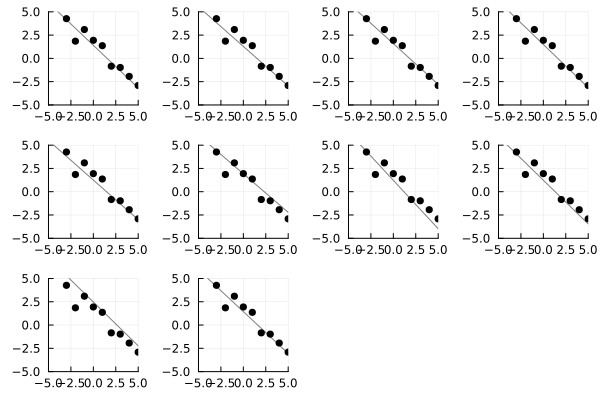

In [37]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
grid(render_trace, traces)

In [38]:
function overlay(renderer, traces; same_data=true, args...)
    fig = renderer(traces[1], show_data=true, args...)
    
    xs, = get_args(traces[1])
    xmin = minimum(xs)
    xmax = maximum(xs)

    for i=2:length(traces)
        y = get_retval(traces[i])
        test_xs = collect(range(-5, stop=5, length=1000))
        fig = plot!(test_xs, map(y, test_xs), color="black", alpha=0.5, label=nothing,
                    xlim=(xmin, xmax), ylim=(xmin, xmax))
    end
    return fig
end;

  0.163766 seconds (2.14 M allocations: 108.035 MiB, 11.18% gc time, 49.38% compilation time)


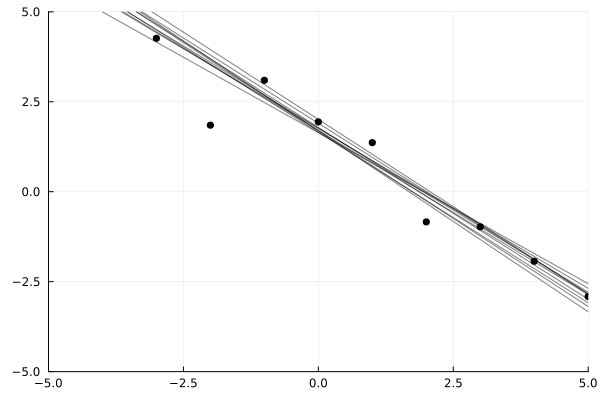

In [39]:
@time begin
traces = [do_inference(line_model, xs, ys, 1000) for _=1:10];
overlay(render_trace, traces)
end

1000 seems to be the best; it doesn't take too long to run, but seems to always generate the best fit line (or close to it); there is still quite a lot of variability when using the lower values. In particular, 1 and 10 are very clearly not fit enough to the data. On the other hand, if we were running this test on the order of tens of thousands of times, then we might have to consider whether the increased accuracy is worth the additional computation time.

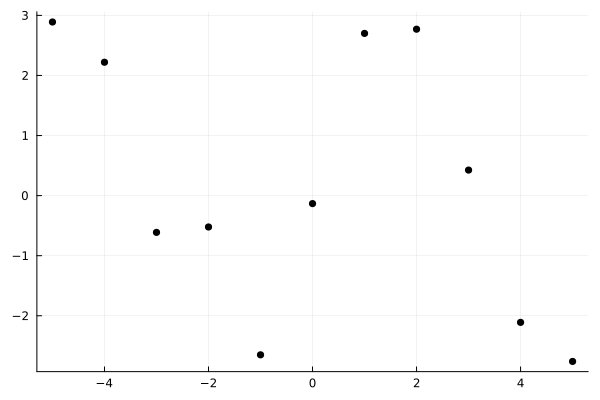

In [40]:
ys_sine = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];
scatter(xs, ys_sine, color="black", label=nothing)

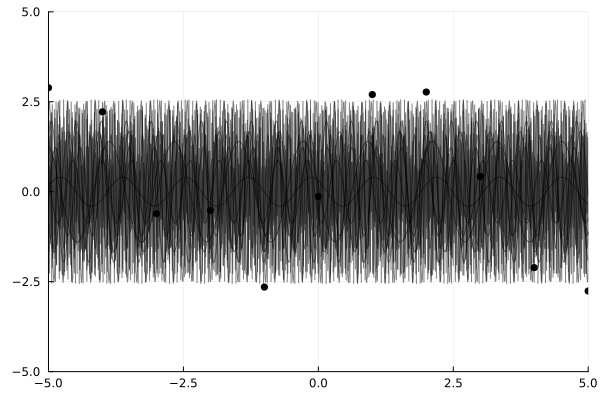

In [50]:
# while this works, it's not very intuitive; let's plot the periods instead
traces = [do_inference(sine_model, xs, ys_sine, 100) for _=1:10];
overlay(render_trace, traces)

In [51]:
Gen.get_choices(traces[3])

│
├── (:y, 11) : -2.76
│
├── (:y, 3) : -0.612
│
├── (:y, 1) : 2.89
│
├── (:y, 8) : 2.77
│
├── (:y, 7) : 2.7
│
├── (:y, 5) : -2.65
│
├── (:y, 6) : -0.133
│
├── (:y, 10) : -2.11
│
├── :amplitude : 2.2849601996506714
│
├── :phase : 5.830650648997829
│
├── :period : 0.025512074401704506
│
├── (:y, 4) : -0.522
│
├── (:y, 2) : 2.22
│
└── (:y, 9) : 0.425


In [52]:
traces = [do_inference(sine_model, xs, ys_sine, 1000) for _=1:100];
periods = [Gen.get_choices(trace)[:period] for trace in traces];
amplitudes = [Gen.get_choices(trace)[:amplitude] for trace in traces];

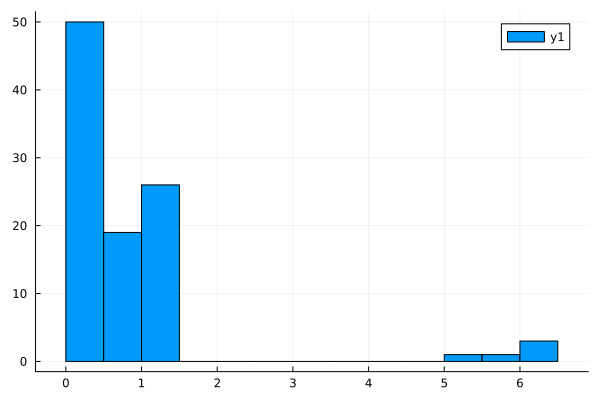

In [53]:
histogram(periods)

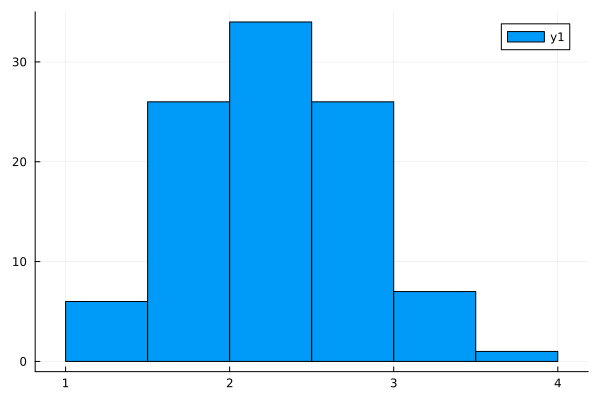

In [54]:
histogram(amplitudes)

Using a Gamma(5, 1) distribution instead makes it much more unlikely to choose a low period; thus, the super-high frequency graphs are no longer shown in the overlay, and we see that the periods tend to be around 6 rather than around 0.

# Part 4

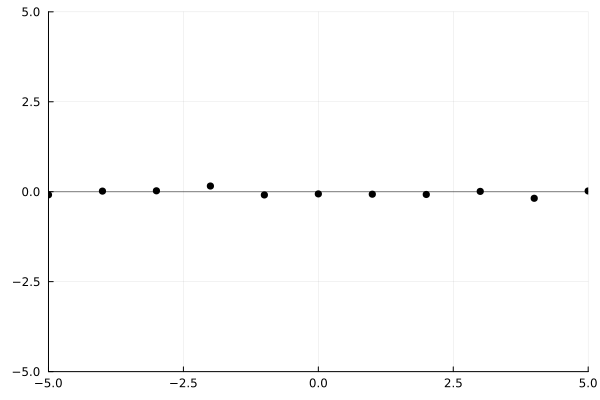

In [55]:
constraints = Gen.choicemap()
constraints[:slope] = 0.
constraints[:intercept] = 0.
(trace, _) = Gen.generate(line_model, (xs,), constraints)
render_trace(trace)

In [56]:
function predict_new_data(model, trace, new_xs::Vector{Float64}, param_addrs)
    
    # Copy parameter values from the inferred trace (`trace`)
    # into a fresh set of constraints.
    constraints = Gen.choicemap()
    for addr in param_addrs
        constraints[addr] = trace[addr]
    end
    
    # Run the model with new x coordinates, and with parameters 
    # fixed to be the inferred values.
    (new_trace, _) = Gen.generate(model, (new_xs,), constraints)
    
    # Pull out the y-values and return them.
    ys = [new_trace[(:y, i)] for i=1:length(new_xs)]
    return ys
end;

In [57]:
function infer_and_predict(model, xs, ys, new_xs, param_addrs, num_traces, amount_of_computation)
    pred_ys = []
    for i=1:num_traces
        trace = do_inference(model, xs, ys, amount_of_computation)
        push!(pred_ys, predict_new_data(model, trace, new_xs, param_addrs))
    end
    pred_ys
end;

In [58]:
function plot_predictions(xs, ys, new_xs, pred_ys; title="predictions")
    fig = scatter(xs, ys, color="red", label="observed data", title=title)
    for (i, pred_ys_single) in enumerate(pred_ys)
        scatter!(new_xs, pred_ys_single, color="black", alpha=0.1, label=i == 1 ? "predictions" : nothing)
    end
    return fig
end;

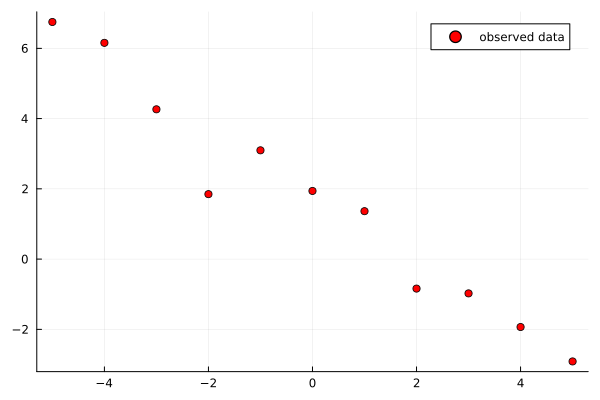

In [59]:
scatter(xs, ys, color="red", label="observed data")

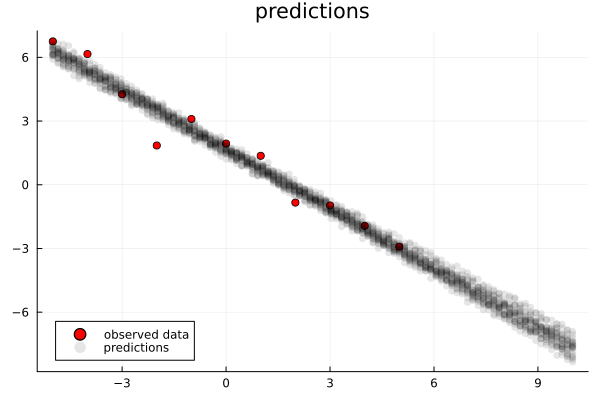

In [60]:
new_xs = collect(range(-5, stop=10, length=100));
pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
plot_predictions(xs, ys, new_xs, pred_ys)


In [90]:
@gen function line_model_fancy(xs::Vector{Float64})
    slope = ({:slope} ~ normal(0, 1))
    intercept = ({:intercept} ~ normal(0, 2))
    
    function y(x)
        return slope * x + intercept
    end
    
    noise = ({:noise} ~ gamma(1, 1))
    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(slope * x + intercept, noise)
    end
    return y
end;

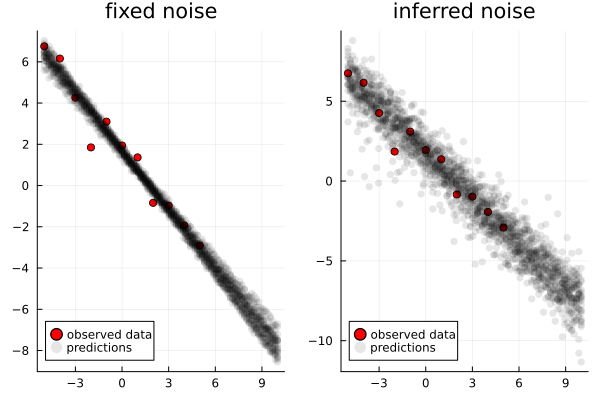

In [62]:
pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
fixed_noise_plot = plot_predictions(xs, ys, new_xs, pred_ys; title="fixed noise")

pred_ys = infer_and_predict(line_model_fancy, xs, ys, new_xs, [:slope, :intercept, :noise], 20, 10000)
inferred_noise_plot = plot_predictions(xs, ys, new_xs, pred_ys; title="inferred noise")

plot(fixed_noise_plot, inferred_noise_plot)

In [63]:
ys_noisy = [5.092, 4.781, 2.46815, 1.23047, 0.903318, 1.11819, 2.10808, 1.09198, 0.0203789, -2.05068, 2.66031];


In [124]:
@gen function sine_model_fancy(xs::Vector{Float64})

    phase = ({:phase} ~ uniform(0, 2 * pi))
    amplitude = ({:amplitude} ~ gamma(1, 1))
    period = ({:period} ~ gamma(5, 1))


    noise = ({:noise} ~ gamma(1, 1))

    function y(x)
        return amplitude * sin(2 * pi * x / period + phase)
    end
    
    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(y(x), noise)
    end
    
    return y
end;

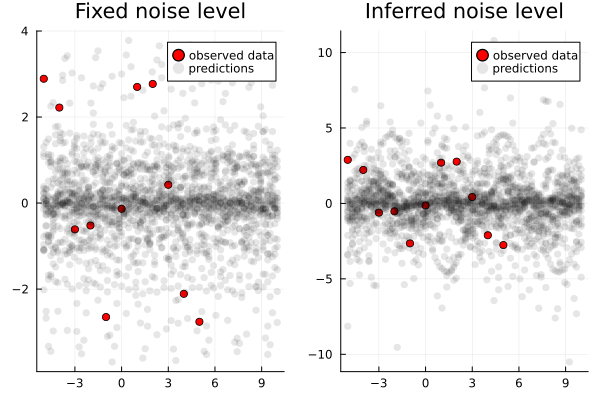

In [125]:
# Modify the line below to experiment with the amount_of_computation parameter
pred_ys = infer_and_predict(sine_model, xs, ys_sine, new_xs, [], 20, 100)
fixed_noise_plot = plot_predictions(xs, ys_sine, new_xs, pred_ys; title="Fixed noise level")

# Modify the line below to experiment with the amount_of_computation parameter
pred_ys = infer_and_predict(sine_model_fancy, xs, ys_sine, new_xs, [], 20, 100)
inferred_noise_plot = plot_predictions(xs, ys_sine, new_xs, pred_ys; title="Inferred noise level")

Plots.plot(fixed_noise_plot, inferred_noise_plot)

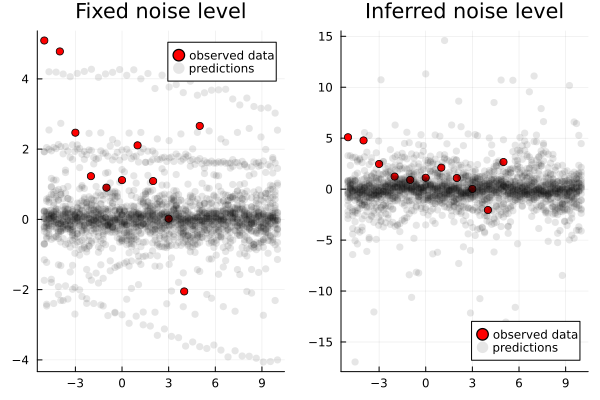

In [126]:
# Modify the line below to experiment with the amount_of_computation parameter
pred_ys = infer_and_predict(sine_model, xs, ys_noisy, new_xs, [], 20, 10000)
fixed_noise_plot = plot_predictions(xs, ys_noisy, new_xs, pred_ys; title="Fixed noise level")

# Modify the line below to experiment with the amount_of_computation parameter
pred_ys = infer_and_predict(sine_model_fancy, xs, ys_noisy, new_xs, [], 20, 10000)
inferred_noise_plot = plot_predictions(xs, ys_noisy, new_xs, pred_ys; title="Inferred noise level")

Plots.plot(fixed_noise_plot, inferred_noise_plot)

The predictions tend to be centered at the mean of the data points, with a fixed noise; it is unable to fully capture the sine signal. This is because our Gamma(1, 1) distribution for the noise is large enough to capture all of the variation in the data set. If we lower the distribution of noise (and use the Gamma(5, 1) distribution for the period), then we get slightly better results.

# Part 5

In [85]:
@gen function foo()
    {:y} ~ normal(0, 1)
end

@gen function bar()
    {:x} ~ bernoulli(0.5)
    # Call `foo` with a wildcard address.
    # Its choices (:y) will appear directly
    # within the trace of `bar`.
    {*} ~ foo()
end

@gen function bar_using_namespace()
    {:x} ~ bernoulli(0.5)
    # Call `foo` with the address `:z`.
    # The internal choice `:y` of `foo`
    # will appear in our trace at the
    # hierarchical address `:z => :y`.
    {:z} ~ foo()
end;

In [86]:
trace = Gen.simulate(bar, ())
Gen.get_choices(trace)

│
├── :y : 1.567228641756482
│
└── :x : true


In [87]:
trace = Gen.simulate(bar_using_namespace, ())
Gen.get_choices(trace)

│
├── :x : true
│
└── :z
    │
    └── :y : 0.851806145877893


In [119]:
@gen function combined_model(xs::Vector{Float64})
    if ({:is_line} ~ bernoulli(0.5))
        # Call line_model_fancy on xs, and import
        # its random choices directly into our trace.
        return ({*} ~ line_model_fancy(xs))
    else
        # Call sine_model_fancy on xs, and import
        # its random choices directly into our trace
        return ({*} ~ sine_model_fancy(xs))
    end
end;

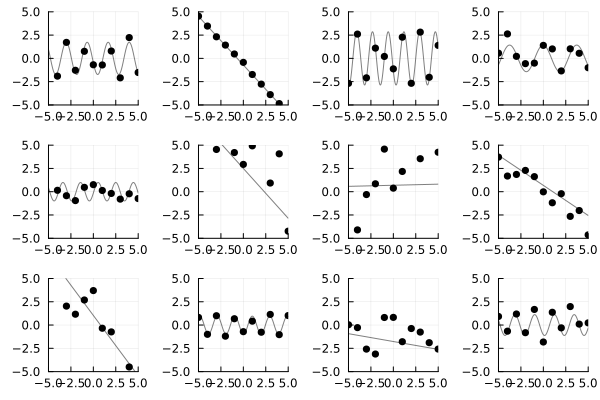

In [129]:
traces = [Gen.simulate(combined_model, (xs,)) for _=1:12]
grid(render_trace, traces)


In [154]:
traces[1][:is_line]

true

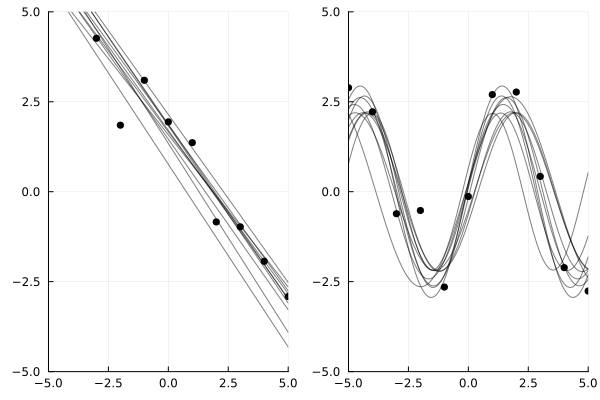

In [130]:
traces = [do_inference(combined_model, xs, ys, 10000) for _=1:10];
linear_dataset_plot = overlay(render_trace, traces)
traces = [do_inference(combined_model, xs, ys_sine, 10000) for _=1:10];
sine_dataset_plot = overlay(render_trace, traces)
Plots.plot(linear_dataset_plot, sine_dataset_plot)

In [172]:
ambiguous_ys = [0, 0.3, 0.1, 0.1, 0.1, 0.3, 0.1, 0.3, 0.1, -0.1, 0.3] * 4;

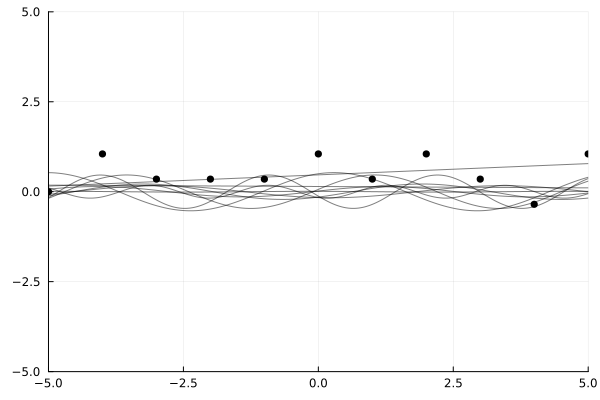

In [166]:
traces = [do_inference(combined_model, xs, ambiguous_ys, 10000) for _=1:10];
overlay(render_trace, traces)

In [156]:
function infer_sine_prob(xs, ys, num_attempts, amount_of_computation)
    count = 0
    for i=1:num_attempts
        trace = do_inference(combined_model, xs, ys, amount_of_computation);
        if !trace[:is_line]
            count+= 1
        end
    end
    return count / num_attempts
end;

In [174]:
infer_sine_prob(xs, ambiguous_ys, 1000, 100)

0.828

# Part 6

In [175]:
xs_dense = collect(range(-5, stop=5, length=50))
ys_simple = fill(1., length(xs_dense)) .+ randn(length(xs_dense)) * 0.1
ys_complex = [Int(floor(abs(x/3))) % 2 == 0 ? 2 : 0 for x in xs_dense] .+ randn(length(xs_dense)) * 0.1;

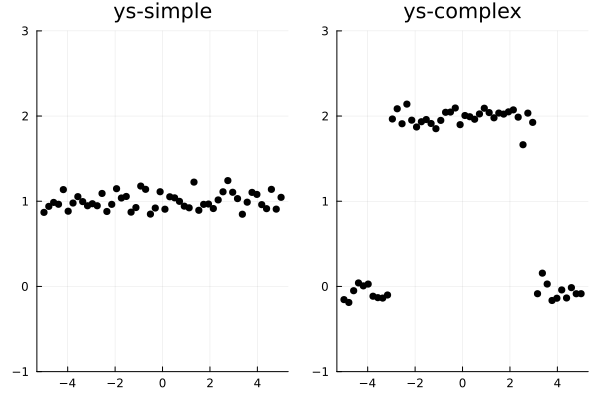

In [176]:
simple_plot = scatter(xs_dense, ys_simple, color="black", label=nothing, title="ys-simple", ylim=(-1, 3))
complex_plot = scatter(xs_dense, ys_complex, color="black", label=nothing, title="ys-complex", ylim=(-1, 3))
Plots.plot(simple_plot, complex_plot)

In [177]:
struct Interval
    l::Float64
    u::Float64
end

In [178]:
abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    value::Float64
    interval::Interval
end

In [180]:
@gen function generate_segments(l::Float64, u::Float64)
    interval = Interval(l, u)
    if ({:isleaf} ~ bernoulli(0.7))
        value = ({:value} ~ normal(0, 1))
        return LeafNode(value, interval)
    else
        frac = ({:frac} ~ beta(2, 2))
        mid  = l + (u - l) * frac
        # Call generate_segments recursively!
        # Because we will call it twice -- one for the left 
        # child and one for the right child -- we use
        # addresses to distinguish the calls.
        left = ({:left} ~ generate_segments(l, mid))
        right = ({:right} ~ generate_segments(mid, u))
        return InternalNode(left, right, interval)
    end
end;

In [181]:
function render_node!(node::LeafNode)
    plot!([node.interval.l, node.interval.u], [node.value, node.value], label=nothing, linewidth=5)
end

function render_node!(node::InternalNode)
    render_node!(node.left)
    render_node!(node.right)
end;

In [182]:
function render_segments_trace(trace; xlim=(0,1))
    node = get_retval(trace)
    fig = plot(xlim=xlim, ylim=(-3, 3))
    render_node!(node)
    return fig
end;

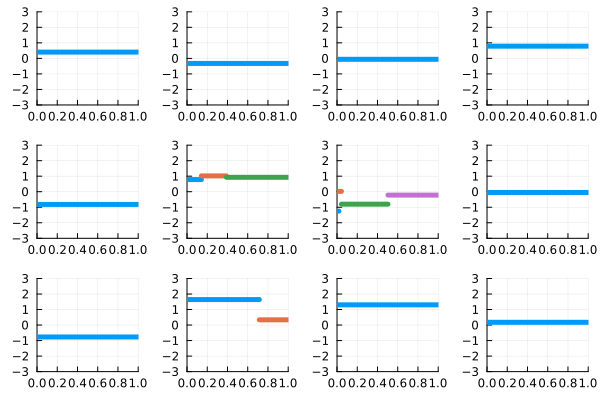

In [183]:
traces = [Gen.simulate(generate_segments, (0., 1.)) for i=1:12]
grid(render_segments_trace, traces)

In [184]:
# get_value_at searches a binary tree for
# the leaf node containing some value.
function get_value_at(x::Float64, node::LeafNode)
    @assert x >= node.interval.l && x <= node.interval.u
    return node.value
end

function get_value_at(x::Float64, node::InternalNode)
    @assert x >= node.interval.l && x <= node.interval.u
    if x <= node.left.interval.u
        get_value_at(x, node.left)
    else
        get_value_at(x, node.right)
    end
end

# Our full model
@gen function changepoint_model(xs::Vector{Float64})
    node = ({:tree} ~ generate_segments(minimum(xs), maximum(xs)))
    noise = ({:noise} ~ gamma(0.5, 0.5))
    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(get_value_at(x, node), noise)
    end
    return node
end;

In [185]:
function render_changepoint_model_trace(trace; show_data=true)
    xs = Gen.get_args(trace)[1]
    node = Gen.get_retval(trace)
    fig = render_segments_trace(trace; xlim=(minimum(xs), maximum(xs)))
    render_node!(node)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        scatter!(xs, ys, c="gray", label=nothing, alpha=0.3, markersize=3)
    end
end;

In [ ]:
traces = [Gen.simulate(changepoint_model, (xs_dense,)) for i=1:12]
grid(render_changepoint_model_trace, traces)

In [ ]:
traces = [do_inference(changepoint_model, xs_dense, ys_simple, 10000) for _=1:12];
grid(render_changepoint_model_trace, traces)

In [ ]:
traces = [do_inference(changepoint_model, xs_dense, ys_complex, 10000) for _=1:12];
grid(render_changepoint_model_trace, traces)

In [195]:
function calc_num_splits(node::LeafNode)
    0
end

function calc_num_splits(node::InternalNode)
    1 + calc_num_splits(node.left) + calc_num_splits(node.right)
end

function hist_num_changepoints(xs, ys, num_iters, amount_of_computation)
    vals = []
    for i=1:num_iters
        trace = do_inference(changepoint_model, xs, ys, amount_of_computation);
        push!(vals, calc_num_splits(trace[:tree]))
    end
    histogram(vals)
end;

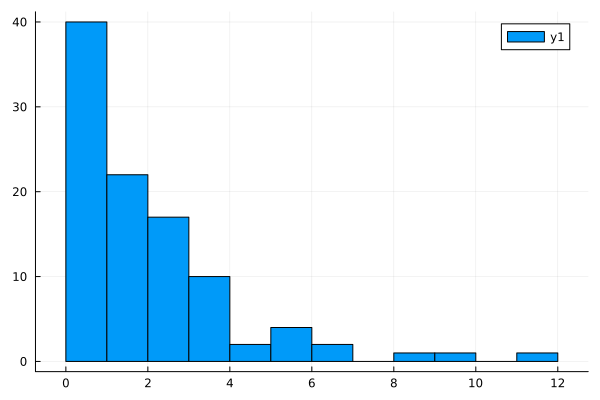

In [196]:
hist_num_changepoints(xs_dense, ys_complex, 100, 1000)

In [ ]:
abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    value::Float64
    interval::Interval
end

In [230]:
# We do basically the same thing, but pass in an address to the constructor.
# This lets us assign the leaves to guaranteed new addresses.
@gen function generate_segments_new(l::Float64, u::Float64, cur_addr::Integer)
    interval = Interval(l, u)
    
    if ({(:isleaf, cur_addr)} ~ bernoulli(0.7))
        value = ({(:value, cur_addr)} ~ normal(0, 1))
        return LeafNode(value, interval)
    else
        frac = ({(:frac, cur_addr)} ~ beta(2, 2))
        mid  = l + (u - l) * frac
        # Call generate_segments recursively!
        # Because we will call it twice -- one for the left 
        # child and one for the right child -- we use
        # addresses to distinguish the calls.
        left = ({*} ~ generate_segments_new(l, mid, cur_addr * 2))
        right = ({*} ~ generate_segments_new(mid, u, cur_addr * 2 + 1))
        return InternalNode(left, right, interval)
    end
end;

In [231]:
@gen function changepoint_model_new(xs::Vector{Float64})
    node = ({:tree} ~ generate_segments_new(minimum(xs), maximum(xs), 1))
    noise = ({:noise} ~ gamma(0.5, 0.5))
    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(get_value_at(x, node), noise)
    end
    return node
end;

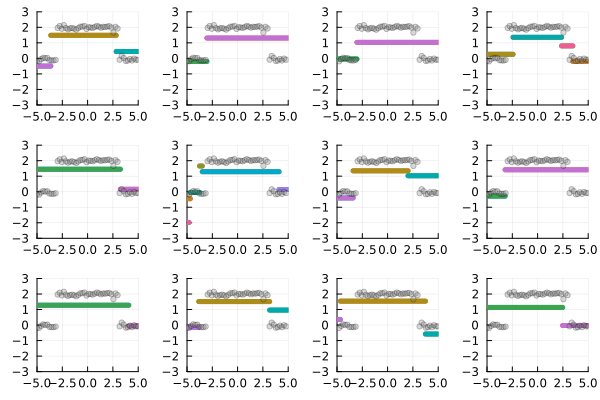

In [232]:
traces = [do_inference(changepoint_model_new, xs_dense, ys_complex, 10000) for _=1:12];
grid(render_changepoint_model_trace, traces)